MBQC, aka one-way quantum computing, is an inventive approach to quantum computing that make use of *off-line* entanglement as a resource for computation. one-way quantum computer는 *cluster state*라고 불리기도 하는 entangled state로부터 시작을 하고 특정한 단일 큐비트 측정을 함. 이러한 맥락서 off-line의 의미는, 얽힘이 rest of computation과 독립적으로 만들어진다는 의미임. In MBQC, the measurements are computation and the entanglement of the cluster state is used as a resource  

이번 예제에서는 cluster state 개념 먼저 소개하고, 어떻게 임의의 양자 회로를 구현하는지 보이면서 MBQC의 universality를 proving할 것. 마지막으로 이 scheme에서 QEC가 이뤄지는지도 다룰 것.

## Cluster states and graph states  
*Cluster states*는 MBQC의 universal substrate. They are a special instance of *graph states*, a class of entangled multi-qubit states that can be represented by an undirected graph $G=(V,E)$ whose vertices $V$ are associated with qubits and teh edge $E$ with entanglement b/w them. The associated quantum state reads as follows  
$$|\Phi\rangle = \Pi_{(i,j)\in E}{CZ_{ij}}|+\rangle^{\otimes n}$$
graph state와 cluster state의 차이는 rather technical하지만 여기서는 cluster state가 graph state의 약간의 조건이 있는 하위 집합인 것만 알아도 됨

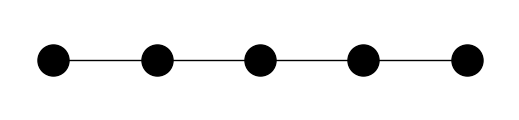

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

a, b = 1, 5 # dimensions of the graph (lattice)
G = nx.grid_graph(dim = [a,b]) # there are a*b qubits

plt.figure(figsize = (5,1))
nx.draw(G, pos = {node: node for node in G}, node_size = 500, node_color = 'black')

이는 꽤나 간단한 cluster state인데, 추후에 이 간단한 그래프가 logical operation에 얼마나 유용한지 볼 것.

In [15]:
import pennylane as qml

qubits = [str(node) for node in G.nodes]
dev = qml.device('lightning.qubit', wires = qubits)

@qml.qnode(dev, interface = 'autograd')
def cluster_state():
    for node in qubits:
        qml.H(wires = [node])

    for edge in G.edges:
        i, j = edge
        qml.CZ(wires = [str(i), str(j)])

    return qml.state()

print(qml.draw(cluster_state)())

(0, 0): ──H─╭●──────────┤  State
(1, 0): ──H─╰Z─╭●───────┤  State
(2, 0): ──H────╰Z─╭●────┤  State
(3, 0): ──H───────╰Z─╭●─┤  State
(4, 0): ──H──────────╰Z─┤  State


Observe that the structure of the circuit is fairly simple. It only requires Hadamard gates on each qubit and then a controlled-Z gate between connected qubits. This part of the computation is not actually computing anything. In fact, aside from the width and depth of the desired quantum circuit, the cluster state generation is essentially independent of the calculation. If you have a reliable way of applying these two operations (Hadamard and controlled-Z), you are ready for the next step: worrying about conditional single-qubit measurements.

## Information propagation and teleportation  
MBQC는 information propagation의 아이디어에 크게 영향을 받는데, 그 중 *quantum teleportation*을 자주 씀. We transport *information*, not matter, b/w systems. 그런데 헷갈리지 말 것은 이 개념이 instantaneous하지는 않다는 것임. 얘는 추가적인 classical information과의 communication이 필요함. which is still limited by teh speed of light

### One-qubit Teleportation  
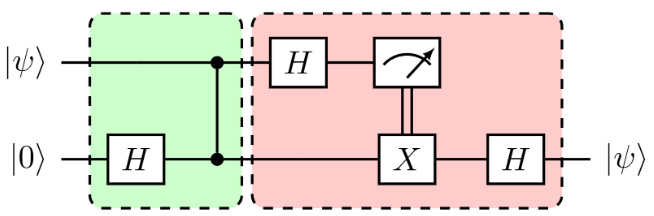

In [28]:
import pennylane as qml
import pennylane.numpy as np

dev = qml.device("lightning.qubit", wires=2)


@qml.qnode(dev, interface="autograd")
def one_bit_teleportation(input_state):
    # Prepare the input state
    qml.StatePrep(input_state, wires=0)

    # Prepare the cluster state
    qml.Hadamard(wires=1)
    qml.CZ(wires=[0, 1])

    # Measure the first qubit in the Pauli-X basis
    # and apply an X-gate conditioned on the outcome
    qml.Hadamard(wires=0)
    m = qml.measure(wires=[0])
    qml.cond(m == 1, qml.PauliX)(wires=1)
    qml.Hadamard(wires=1)

    # Return the density matrix of the output state
    return qml.density_matrix(wires=[1])

In [29]:
# Define helper function for random input state on n qubits
def generate_random_state(n=1):
    input_state = np.random.random(2 ** n) + 1j * np.random.random(2 ** n)
    return input_state / np.linalg.norm(input_state)


# Generate a random input state |psi> for n=1 qubit
input_state = generate_random_state()

density_matrix = np.outer(input_state, np.conj(input_state))
density_matrix_mbqc = one_bit_teleportation(input_state)

np.allclose(density_matrix, density_matrix_mbqc)

True

This protocol is one of the main ingredients of one-way quantum computing. Essentially, we propagate the information in one end of our cluster state to the other end through successive teleportations. In addition, we can “write” our circuit onto the cluster state by choosing the measurements adaptively. In the next section, we will see how we can actually do this.

## Universality of MBQC  
We want to show that a MBQC is a quantum Turing machine. To do this, we need to show 4 things
1. How **information propagtes** through the cluster state
2. How arbitrary **single-qubit rotation** can be implemented
3. How a **two-qubit gate** can be implemented in this scheme
4. How to implement **arbitrary quantum circuits**

we treated 1 above, so will tackle the ramining parts concerning logical operations. 

### Single-qubit rotations  
We can implement single-rotations by using the entanglement of the cluster state. Any single-qubit gate can be represented as a composition of three rotations along two different axes  

We will see that in our meas-based scheme, this operation can be implemented using a linear chain of 5 qubits prepared in cluster state, as shown below. The first qubit $t_in$ is prepared in some input state $|\psi_{in}\rangle$, and we are interested in the final state of the output qubit $t_{out}$  
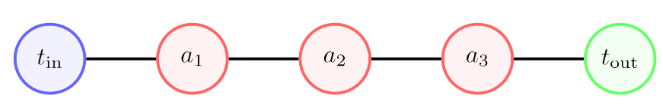  
where input qubit $t_{in}$ together with the intermediate qubits $a_1, a_2, a_3$ are then measured in the bases  
$$B_j(\theta_j) \equiv \{\frac{|0\rangle + e^{i\theta_j}|1\rangle}{\sqrt{2}},
                        \frac{|0\rangle - e^{i\theta_j}|1\rangle}{\sqrt{2}}\}$$
where the angle $\theta_j$ depend on prior measurement outcomes and are given by 
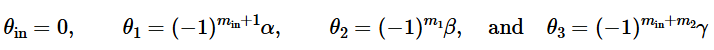
After these operations, the state of qubit $t_{out}$ is given by
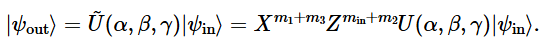
Luckily, we can correct for these additional Pauli gates by choosing the measurement basis of qubit $t_{out}$ appropriately or correcting for them classically after the quantum computation

To start off, we define the $R_z(\theta)$ gate using two qubits with the gate-based approach so we can later compare our MBQC approach to it.

In [32]:
dev = qml.device("lightning.qubit", wires=1)

@qml.qnode(dev, interface="autograd")
def RZ(theta, input_state):
    # Prepare the input state
    qml.StatePrep(input_state, wires=0)

    # Perform the Rz rotation
    qml.RZ(theta, wires=0)

    # Return the density matrix of the output state
    return qml.density_matrix(wires=[0])

In [31]:
mbqc_dev = qml.device("lightning.qubit", wires=2)

@qml.qnode(mbqc_dev, interface="autograd")
def RZ_MBQC(theta, input_state):
    # Prepare the input state
    qml.StatePrep(input_state, wires=0)

    # Prepare the cluster state
    qml.Hadamard(wires=1)
    qml.CZ(wires=[0, 1])

    # Measure the first qubit and correct the state
    qml.RZ(theta, wires=0)
    qml.Hadamard(wires=0)
    m = qml.measure(wires=[0])

    qml.cond(m == 1, qml.PauliX)(wires=1)
    qml.Hadamard(wires=1)

    # Return the density matrix of the output state
    return qml.density_matrix(wires=[1])

In [33]:
# Generate a random input state
input_state = generate_random_state()
theta = 2 * np.pi * np.random.random()

np.allclose(RZ(theta, input_state), RZ_MBQC(theta, input_state))

True

Great. and we can do the same procedure for $R_X(\theta)$

In [ ]:
dev = qml.device("lightning.qubit", wires=1)


@qml.qnode(dev, interface="autograd")
def RX(theta, input_state):
    # Prepare the input state
    qml.StatePrep(input_state, wires=0)

    # Perform the Rz rotation
    qml.RX(theta, wires=0)

    # Return the density matrix of the output state
    return qml.density_matrix(wires=[0])


mbqc_dev = qml.device("lightning.qubit", wires=3)


@qml.qnode(mbqc_dev, interface="autograd")
def RX_MBQC(theta, input_state):
    # Prepare the input state
    qml.StatePrep(input_state, wires=0)

    # Prepare the cluster state
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.CZ(wires=[0, 1])
    qml.CZ(wires=[1, 2])

    # Measure the qubits and perform corrections
    qml.Hadamard(wires=0)
    m1 = qml.measure(wires=[0])

    qml.RZ(theta, wires=1)
    qml.cond(m1 == 1, qml.RX)(-2 * theta, wires=2)
    qml.Hadamard(wires=1)
    m2 = qml.measure(wires=[1])

    qml.cond(m2 == 1, qml.PauliX)(wires=2)
    qml.cond(m1 == 1, qml.PauliZ)(wires=2)

    # Return the density matrix of the output state
    return qml.density_matrix(wires=[2])
    
# Generate a random input state
input_state = generate_random_state()
theta = 2 * np.pi * np.random.random()

np.allclose(RX(theta, input_state), RX_MBQC(theta, input_state))

True

Perfect! We have shown that we can implement any single-axis rotation on an arbitrary state in the MBQC formalism. In the following section we will look at a two-qubit gate to complete our universal gate set.

### The two-qubit gate: CNOT  
The 2nd ingredient for a universal quantum computing scheme is the two-qubit gate. CNOT을 meas-based framework로 하는거 보이겠음. 아래 그림과 같은 cluster state를 보자. $t_in$과 $a$는 $X$-basis에서 측정하고, $c$와 $t_out$의 CNOT을 구현할 것(up to Pauli corrections)  
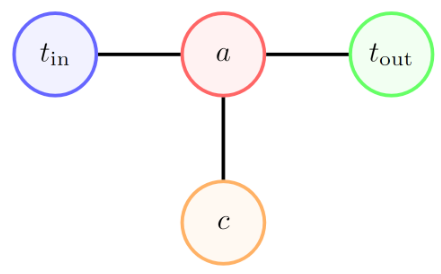

In [39]:
dev = qml.device('lightning.qubit', wires = 2)

@qml.qnode(dev, interface = 'autograd')
def CNOT(input_state):
    qml.StatePrep(input_state, wires = [0,1])
    qml.CNOT(wires = [0,1])

    return qml.density_matrix(wires = [0,1])

mbqc_dev = qml.device('lightning.qubit', wires = 4)
@qml.qnode(mbqc_dev, interface = 'autograd')
def CNOT_MBQC(input_state):
    # Prepare the input state
    qml.StatePrep(input_state, wires=[0, 1])

    # Prepare the cluster state
    qml.Hadamard(wires=2)
    qml.Hadamard(wires=3)
    qml.CZ(wires=[2, 0])
    qml.CZ(wires=[2, 1])
    qml.CZ(wires=[2, 3])

    # Measure the qubits in the appropriate bases
    qml.Hadamard(wires=1)
    m1 = qml.measure(wires=[1])
    qml.Hadamard(wires=2)
    m2 = qml.measure(wires=[2])

    # Correct the state
    qml.cond(m1 == 1, qml.PauliZ)(wires=0)
    qml.cond(m2 == 1, qml.PauliX)(wires=3)
    qml.cond(m1 == 1, qml.PauliZ)(wires=3)

    # Return the density matrix of the output state
    return qml.density_matrix(wires=[0, 3])

In [41]:
input_state = generate_random_state(n=2)
density_matrix = CNOT(input_state)
density_matrix_mbqc = CNOT_MBQC(input_state)

np.allclose(density_matrix, density_matrix_mbqc)

True

### Arbitrary quantum circuits  
Final step is to show that we can implement arbitrary quantum circuits.  

The complete computation can be performed as shown in the figure below. The qubits are teleported along the arrows in the cluster and single-qubit gates are applied through a selection of measurement bases along these arrays. Two-qubit gates are emplemented along vertical arrows, and the rest of the qubits are measured in the $Z$-basis, effectively taking them out of the cluster w/o affectin the neighboring nodes.  
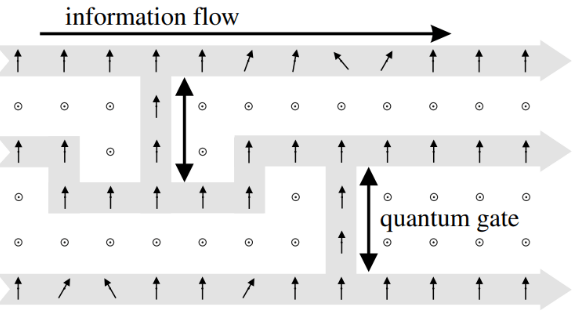  
However, you might wonder: Is it even feasible to construct the large cluster states that one-way quantum computation requires? The number of qubits needed to construct a circuit can grow to be very large, as it not only depends on the number of logical qubits, but also on the depth of the circuit. At this point, it’s good to reiterate that the entanglement of the cluster state is created off-line.  

…the entanglement is created independently from the rest of the computation, like how a blank sheet of paper is made separately from the text of a book.  

Interestingly enough, we do not have to prepare all of the entanglement at once. Just like we can already start printing text upon the first few pages, we can apply measurements to one end of the cluster while growing it at the same time, as shown in the figure below. That is, we can start printing the text on the first few pages while at the same time reloading the printer’s paper tray!  
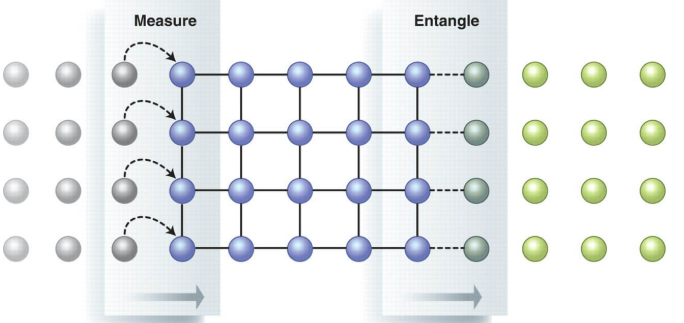